### Imports

In [1]:
import cv2
import time

import numpy as np
import matplotlib.pyplot as plt

from helpers.limbus_detection import detect_circle
from helpers.video_manipulation import extract_consecutive
from helpers.orientation_detection import detect_markers_entropy, polar_transform

%load_ext autoreload
%autoreload 2

### extracting consecutive frames

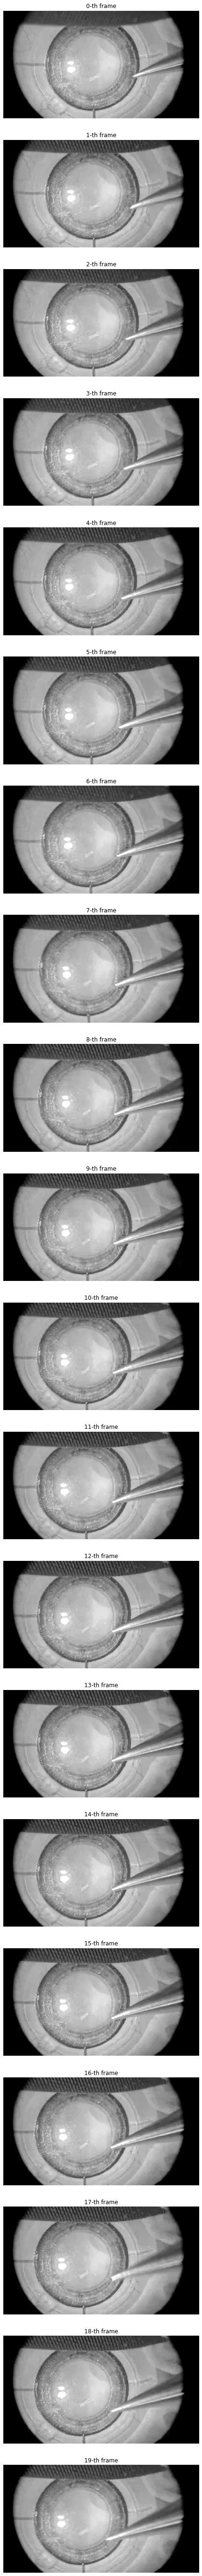

In [2]:
video_path = 'data/artificial/procedure5_lofi.mkv'

frame_start = 43*30
frame_count = 20
frames = extract_consecutive(video_path, frame_start, frame_start+frame_count, mode='hsv')

_, plots = plt.subplots(len(frames), 1, figsize=(15, 5*len(frames)))
for i, frame in enumerate(frames):
    plots[i].set_title('%s-th frame' % i)
    plots[i].imshow(frame[:,:,2], cmap='gray')
    plots[i].axis('off')

plt.show()

### precomputing stuff

In [3]:
limbus_circles = []
orientation_degrees = []
polar_segmentations = []
polar_transforms = []

for frame in frames:
    circle = detect_circle(frame[:,:,2], validation='inout')
    degree, _, polar_segmentation, _ = detect_markers_entropy(
        frame, circle[:2], circle[2], return_verbose=True)
    
    limbus_circles.append(circle)
    orientation_degrees.append(degree)
    polar_segmentations.append(polar_segmentation)
    polar_transforms.append(polar_transform(frame[:,:,2], circle[:2], circle[2]))


### feature detection test

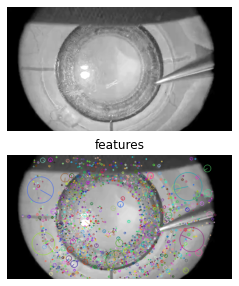

1571 keypoints detected


In [4]:
# keypoint_target = polar_transforms[-1]
keypoint_target = frames[0][:,:,2]

sift = cv2.SIFT_create(contrastThreshold=0.01)
# sift = cv2.ORB_create()
sift_keypoints = sift.detect(keypoint_target, None)

keypoint_target_result = cv2.drawKeypoints(keypoint_target, sift_keypoints, None,
                                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, (plot1, plot2) = plt.subplots(2, 1, figsize=(20,5))
plot1.set_title('')
plot1.imshow(keypoint_target, cmap='gray')
plot1.axis('off')

plot2.set_title('features')
plot2.imshow(cv2.cvtColor(keypoint_target_result, cv2.COLOR_BGR2RGB))
plot2.axis('off')

plt.show()

print('%s keypoints detected' % len(sift_keypoints))

### feature detection + matching test

116 good matches found


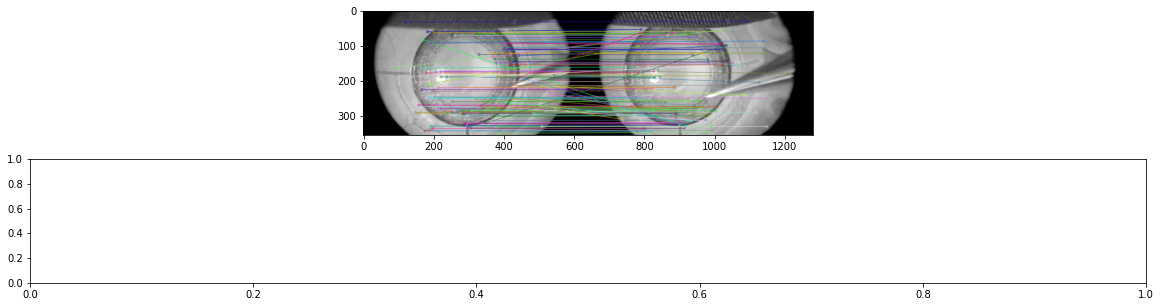

(<matplotlib.image.AxesImage at 0x7ff4cb6957c0>, None)

In [5]:
# keypoint_target_from = polar_transforms[0]
# keypoint_target_to = polar_transforms[-1]
keypoint_target_from = frames[0][:,:,2]
keypoint_target_to = frames[-1][:,:,2]

# Initiate SIFT detector
sift = cv2.SIFT_create(contrastThreshold=0.01)
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(keypoint_target_from,None)
kp2, des2 = sift.detectAndCompute(keypoint_target_to,None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        
print('%s good matches found' % len(good))
        
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(keypoint_target_from,kp1,keypoint_target_to,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig, plots = plt.subplots(2, 1, figsize=(20,5))
plots[0].imshow(img3),plt.show()

### analyzing matches

In [13]:
print(kp1[good[0][0].queryIdx].pt)
print(kp2[good[0][0].trainIdx].pt)
np.linalg.norm(np.array(kp1[good[0][0].queryIdx].pt) - np.array(kp2[good[0][0].trainIdx].pt))

(92.02786254882812, 160.53665161132812)
(403.355712890625, 50.549522399902344)


330.18509807472407

In [14]:
x_dists = []
dists = []

for matches in good:
    match = matches[0]
    
    x_dists.append(
        kp1[match.queryIdx].pt[0] - kp2[match.trainIdx].pt[0])
    dists.append(
        np.linalg.norm(np.array(kp1[match.queryIdx].pt) - np.array(kp2[match.trainIdx].pt)))

In [8]:
len(dists)

116

### estimating transformation (scale + rotation + translation) from matches

In [9]:
transform, inliers = cv2.estimateAffinePartial2D(
    np.array([kp1[m[0].queryIdx].pt for m in good]),
    np.array([kp2[m[0].trainIdx].pt for m in good])
)
print(transform)

[[ 9.89878789e-01  5.91665749e-03 -3.21216647e+01]
 [-5.91665749e-03  9.89878789e-01  3.89842469e+00]]


In [10]:
def get_transform_info(transform):
    a = transform[0,0]
    b = transform[1,0]
    alpha = np.arctan2(b, a)
    s = a / np.cos(alpha)
    
    print('translation: %s, rotation angle: %s, scale: %s' % (transform[:,2], alpha, s))

In [11]:
get_transform_info(transform)

translation: [-32.12166475   3.89842469], rotation angle: -0.0059770823428167315, scale: 0.9898964712393769


In [12]:
(inliers == 1).sum()

50